## **The Task**

In this hackathon, we want you to build machine learning models to predict COVID-19 infections from symptoms. It has several applications – for example, triaging patients to be attended by a doctor or nurse, recommending self-isolation through contact tracing apps, etc.

## **Packagaes and Initial Data Load**

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


In [2]:
#Load in data
corona_data = pd.read_csv('../Data/corona_tested_individuals_ver_006.english.csv')

C:\Users\BWEST1\AppData\Local\Temp\ipykernel_56500\2123349546.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  corona_data = pd.read_csv('../Data/corona_tested_individuals_ver_006.english.csv')


## **Initial EDA**

In [3]:
#Check raw data
corona_data.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
1,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
2,2020-04-30,0.0,1.0,0.0,0.0,0.0,negative,NaN,male,Other
3,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
4,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,male,Other


In [4]:
#Check shape of data
num_rows = corona_data.shape[0]
num_cols = corona_data.shape[1]

print(f"Data has {num_rows} rows")
print(f"Data has {num_cols} columns")

Data has 278848 rows
Data has 10 columns


In [5]:
corona_data.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache
count,278596.000000,278596.000000,278847.000000,278847.000000,278847.000000
mean,0.151574,0.078077,0.006907,0.005655,0.008657
std,0.358608,0.268294,0.082821,0.074990,0.092640
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
corona_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   test_date            278848 non-null  object 
 1   cough                278596 non-null  float64
 2   fever                278596 non-null  float64
 3   sore_throat          278847 non-null  float64
 4   shortness_of_breath  278847 non-null  float64
 5   head_ache            278847 non-null  float64
 6   corona_result        278848 non-null  object 
 7   age_60_and_above     151528 non-null  object 
 8   gender               259285 non-null  object 
 9   test_indication      278848 non-null  object 
dtypes: float64(5), object(5)
memory usage: 21.3+ MB


In [7]:
#Check data types
corona_data_types = corona_data.dtypes
corona_data_types

test_date               object
cough                  float64
fever                  float64
sore_throat            float64
shortness_of_breath    float64
head_ache              float64
corona_result           object
age_60_and_above        object
gender                  object
test_indication         object
dtype: object

In [8]:
#Check which columns have nas and how many nas are in each column
print("Does column contain NA values?")
print(corona_data.isna().any())

print("How many NA values?")
corona_data.isna().sum()

Does column contain NA values?
test_date              False
cough                   True
fever                   True
sore_throat             True
shortness_of_breath     True
head_ache               True
corona_result          False
age_60_and_above        True
gender                  True
test_indication        False
dtype: bool
How many NA values?


test_date                   0
cough                     252
fever                     252
sore_throat                 1
shortness_of_breath         1
head_ache                   1
corona_result               0
age_60_and_above       127320
gender                  19563
test_indication             0
dtype: int64

In [9]:
#Check distribution of target(?) variable
print(corona_data['corona_result'].value_counts(normalize=True))

print("We can see there seems to be a significant class imbalance - 93.3% negative cases vs 5.3% positive vs 1.3% other")

corona_result
negative    0.933222
positive    0.052821
other       0.013957
Name: proportion, dtype: float64
We can see there seems to be a significant class imbalance - 93.3% negative cases vs 5.3% positive vs 1.3% other


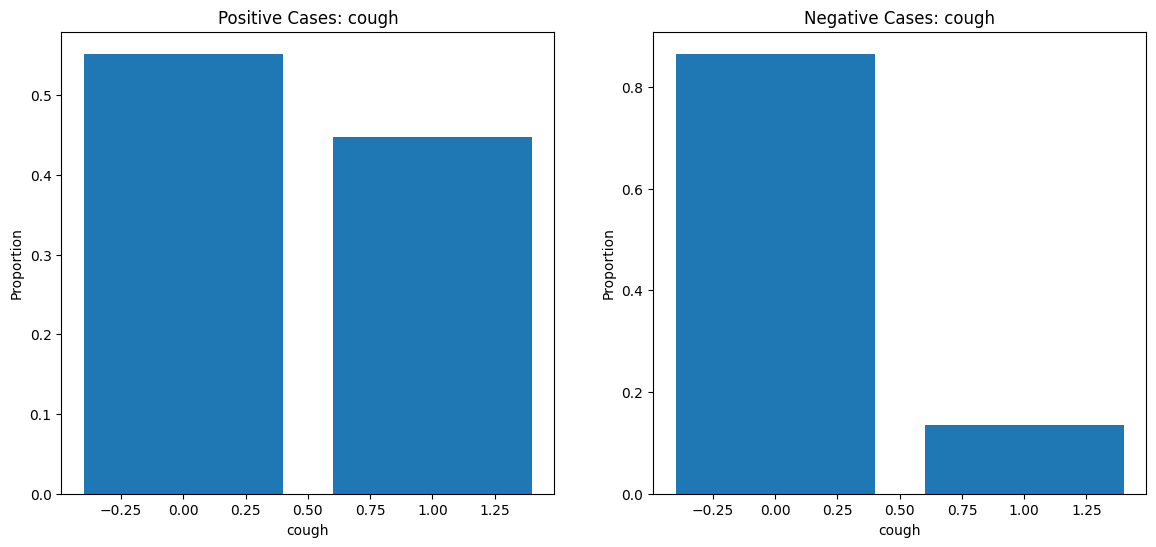

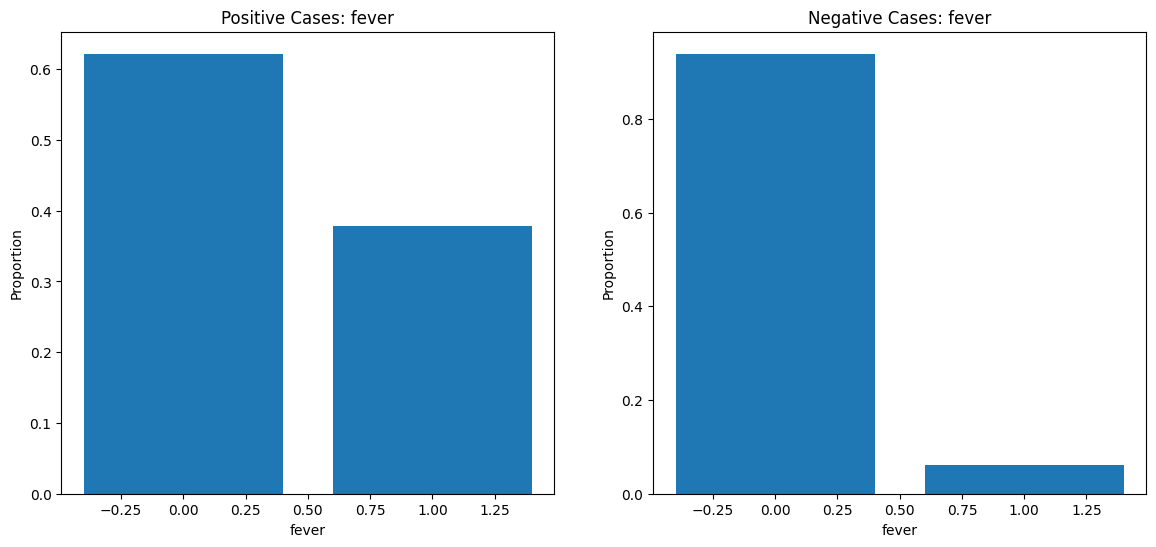

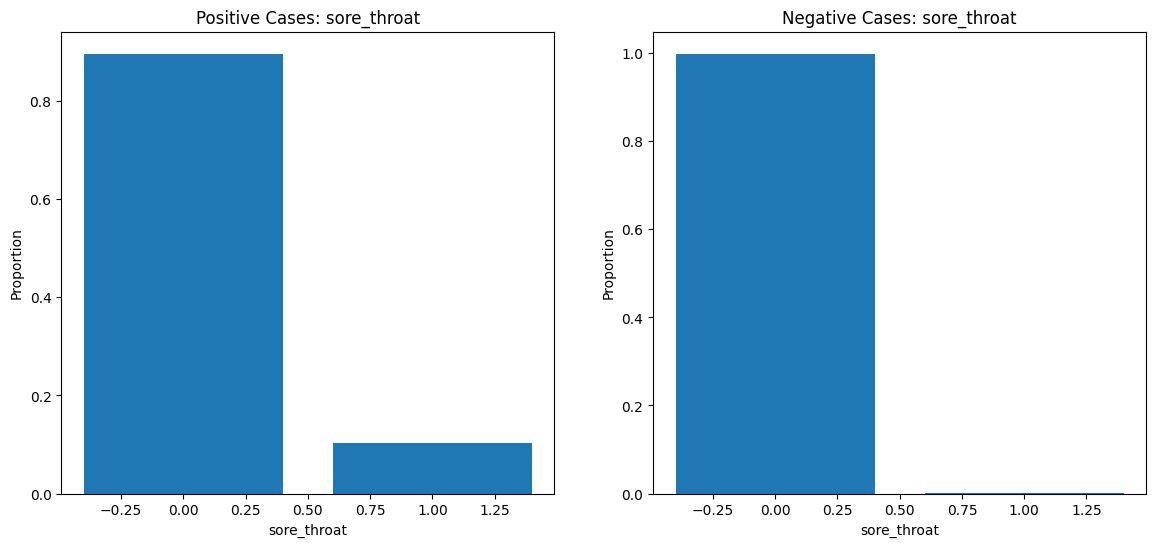

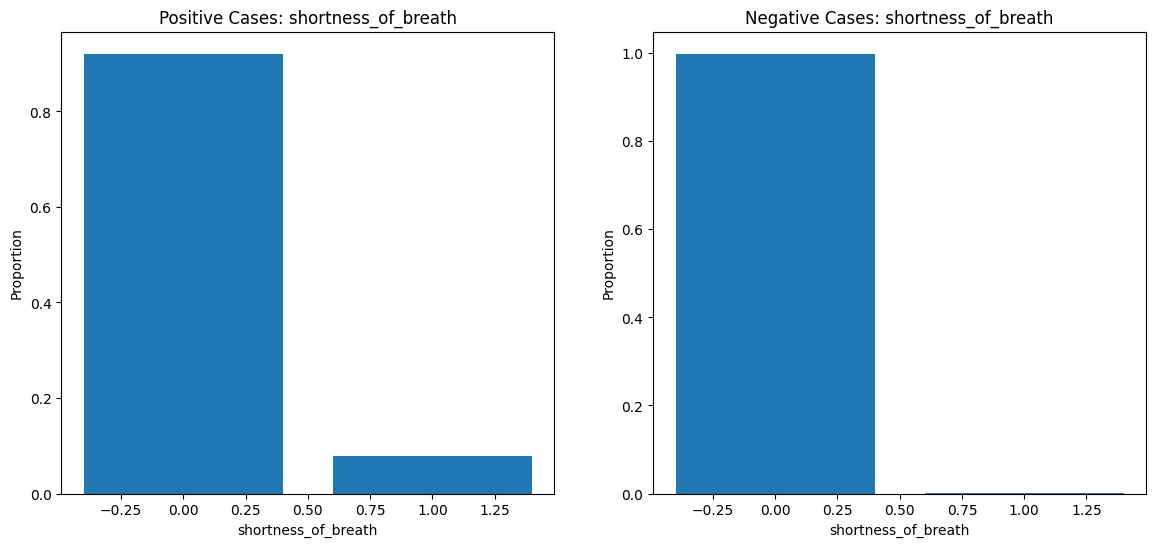

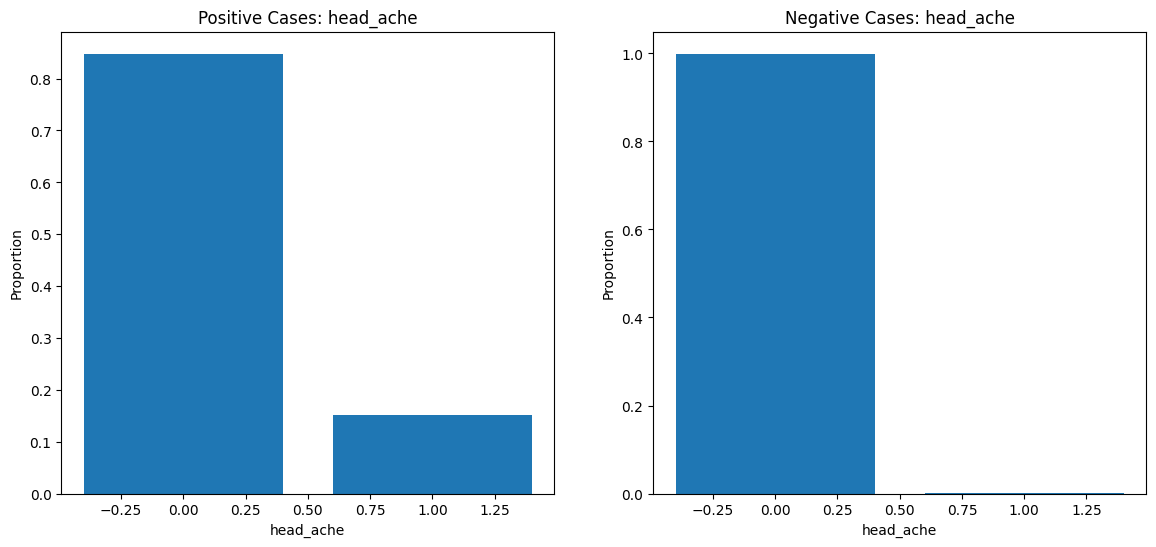

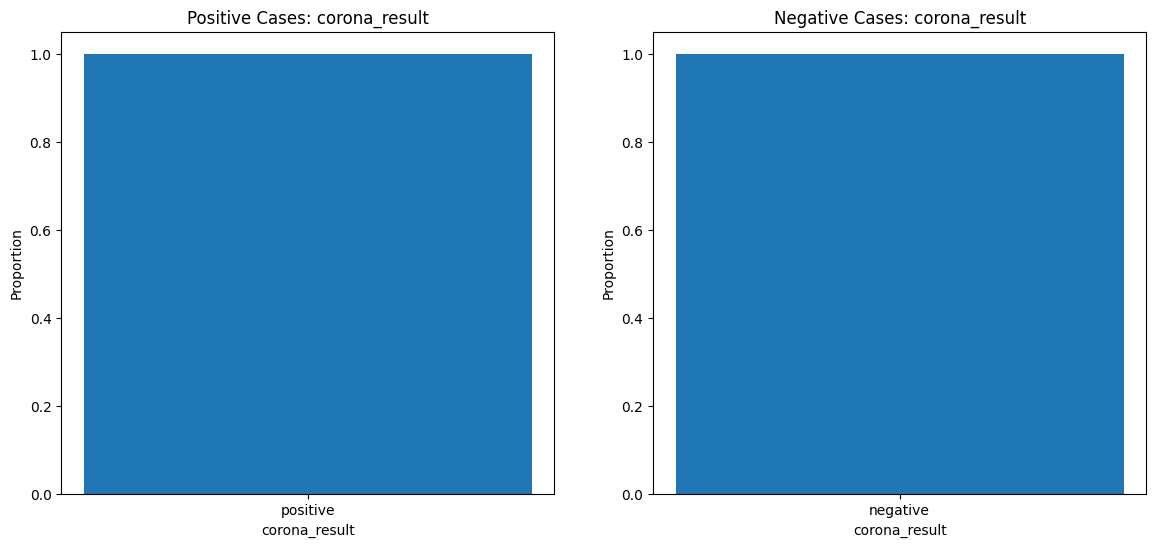

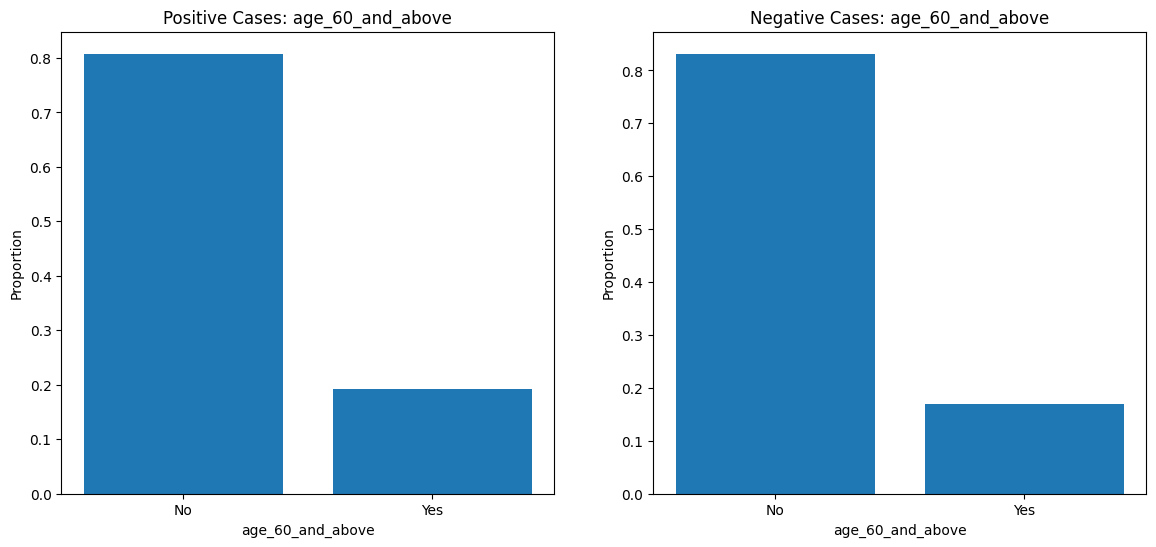

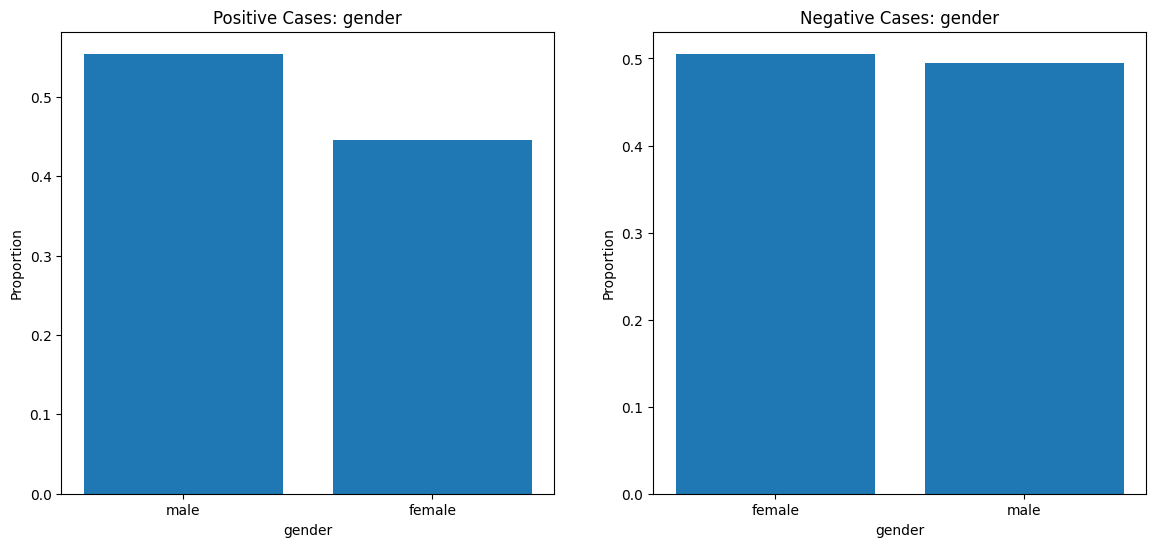

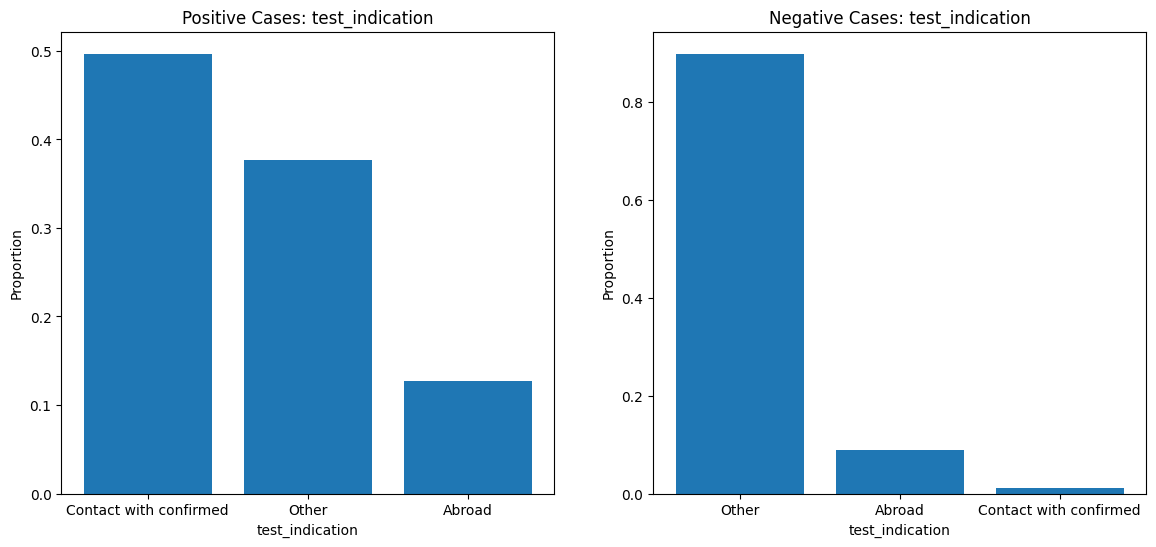

In [10]:
positive_cases = corona_data[corona_data['corona_result'] == "positive"]
negative_cases = corona_data[corona_data['corona_result'] == "negative"]

for c in corona_data.columns:
    #Exclude test date because it's lots of different values
    if c != 'test_date':
        val_counts_p = positive_cases[c].value_counts(normalize=True)
        val_counts_n = negative_cases[c].value_counts(normalize=True)

         # Create subplots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
        
        # Plot positive cases
        axes[0].bar(val_counts_p.index, val_counts_p.values)
        axes[0].set_title(f'Positive Cases: {c}')
        axes[0].set_xlabel(c)
        axes[0].set_ylabel('Proportion')
        
        # Plot negative cases
        axes[1].bar(val_counts_n.index, val_counts_n.values)
        axes[1].set_title(f'Negative Cases: {c}')
        axes[1].set_xlabel(c)
        axes[1].set_ylabel('Proportion')

<Axes: xlabel='corona_result', ylabel='count'>

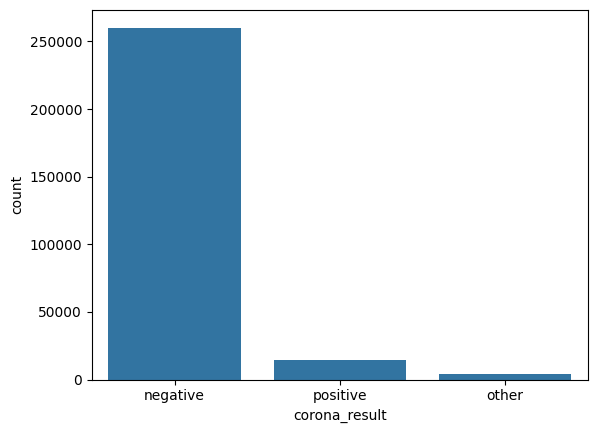

In [11]:
sns.countplot(data=corona_data, x='corona_result')

## **Pre-Processing**

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE

### **Filling Missing Values**

In [13]:
corona_data.isna().sum()

test_date                   0
cough                     252
fever                     252
sore_throat                 1
shortness_of_breath         1
head_ache                   1
corona_result               0
age_60_and_above       127320
gender                  19563
test_indication             0
dtype: int64

In [14]:
#Some columns have minimal nas so we can probably get away with just dropping these
cols_to_check = ['sore_throat','shortness_of_breath','head_ache']

corona_data_clean = corona_data.dropna(subset=cols_to_check)

print(corona_data.shape)
print(corona_data_clean.shape)

print(corona_data_clean.isna().sum())

(278848, 10)
(278847, 10)
test_date                   0
cough                     251
fever                     251
sore_throat                 0
shortness_of_breath         0
head_ache                   0
corona_result               0
age_60_and_above       127319
gender                  19562
test_indication             0
dtype: int64


In [15]:
#Others are slightly more involved - as an initial pass just fill these in with 'missing'
corona_data_clean.loc[:,'age_60_and_above'] = corona_data_clean.loc[:,'age_60_and_above'].fillna('No')
corona_data_clean.loc[:,'gender'] = corona_data_clean.loc[:,'gender'].fillna('missing')
corona_data_clean.loc[:,'cough'] = corona_data_clean.loc[:,'cough'].fillna(0)
corona_data_clean.loc[:,'fever'] = corona_data_clean.loc[:,'fever'].fillna(0)

#Check nas again
print(corona_data_clean.isna().sum())

test_date              0
cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
corona_result          0
age_60_and_above       0
gender                 0
test_indication        0
dtype: int64


In [16]:
corona_data_clean.dtypes

test_date               object
cough                  float64
fever                  float64
sore_throat            float64
shortness_of_breath    float64
head_ache              float64
corona_result           object
age_60_and_above        object
gender                  object
test_indication         object
dtype: object

In [17]:
#Drop test_result = 'Other'
corona_data_clean = corona_data_clean[corona_data_clean['corona_result'] != 'other']

### **Other Data**

Maybe we could match in some other data to test out some new indicators/try and boost performance. Using [Google mobility data](https://www.google.com/covid19/mobility/) might give as a sense of how much people were moving around on particular days in Israel.

Then match test date on a slightly lagged mobility data date to account for symptom development?

In [18]:
#Check date range of og data set
max_date = corona_data['test_date'].max()
min_date = corona_data['test_date'].min()

print(f"Max Date: {max_date}")
print(f"Min Date: {min_date}")

Max Date: 2020-04-30
Min Date: 2020-03-11


In [19]:
#Work out lagged min date so we can account for symptom incubation
min_test_date = datetime.strptime(min_date, "%Y-%m-%d") - timedelta(days=5)
lagged_min_test_date = min_test_date.strftime(format="%Y-%m-%d")
lagged_min_test_date

'2020-03-06'

In [20]:
mobility_data = pd.read_csv('../Data/israel_mobility_data.csv')

mobility_data['date'] = pd.to_datetime(mobility_data['date'])

#Filter mobility data on lagged min date
mobility_data_valid = mobility_data[mobility_data['date'] >= lagged_min_test_date ]

#Exclude anything after max date
mobility_data_valid = mobility_data_valid[mobility_data_valid['date'] <= max_date]

#Filter to include overall Israel only
mobility_data_valid = mobility_data_valid[mobility_data_valid['sub_region_1'].isna()]

mobility_data_valid.tail()

#Keep column subset
# Keep the 'Date' column and columns that include the word "baseline"
columns_to_keep = ['date'] + [col for col in mobility_data_valid.columns if 'baseline' in col]
mobility_data_valid = mobility_data_valid[columns_to_keep]

symptom_lag = 3

#Add new +5 days date column that we can match on to get stats from 5 days previous
mobility_data_valid['date_match'] = mobility_data_valid['date'] + timedelta(days=symptom_lag)

mobility_data_valid.head()

mobility_data_valid['date_match'] = mobility_data_valid['date_match'].astype('str')

C:\Users\BWEST1\AppData\Local\Temp\ipykernel_56500\689958606.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  mobility_data['date'] = pd.to_datetime(mobility_data['date'])


In [21]:
#Match on to og data set
combined_data = pd.merge(corona_data_clean, mobility_data_valid, how="left", left_on="test_date",right_on="date_match")

combined_data.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,date_match
0,2020-04-30,0.0,0.0,0.0,0.0,0.0,negative,No,female,Other,2020-04-27,-61.0,-4.0,-36.0,-46.0,-48.0,25.0,2020-04-30
1,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,No,female,Other,2020-04-27,-61.0,-4.0,-36.0,-46.0,-48.0,25.0,2020-04-30
2,2020-04-30,0.0,1.0,0.0,0.0,0.0,negative,No,male,Other,2020-04-27,-61.0,-4.0,-36.0,-46.0,-48.0,25.0,2020-04-30
3,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,No,female,Other,2020-04-27,-61.0,-4.0,-36.0,-46.0,-48.0,25.0,2020-04-30
4,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,No,male,Other,2020-04-27,-61.0,-4.0,-36.0,-46.0,-48.0,25.0,2020-04-30


Or adding in covid case numbers - this doesn't seem to have any impact so skipping.

In [22]:
case_data = pd.read_csv('../Data/israel_covid_cases.csv')

case_data['date'] = pd.to_datetime(case_data['date'], format="%d/%m/%Y")

#Keep the 'Date' column and columns that include the word "baseline"
columns_to_keep = ['date','new_confirmed']
case_data = case_data[columns_to_keep]

#Filter mobility data on lagged min date
case_data_valid = case_data[case_data['date'] >= lagged_min_test_date ]

#Exclude anything after max date
case_data_valid = case_data_valid[case_data_valid['date'] <= max_date]

#Filter to include overall Israel only
#case_data_valid = case_data_valid[case_data_valid['sub_region_1'].isna()]

case_data_valid.tail()

symptom_lag_cases = 6

#Add new +5 days date column that we can match on to get stats from 5 days previous
case_data_valid['date_match_cases'] = case_data_valid['date'] + timedelta(days=symptom_lag_cases)
case_data_valid.rename(columns={'date': 'date_cases'}, inplace=True)

case_data_valid.head()

case_data_valid = case_data_valid.reset_index(drop=True)

case_data_valid['date_match_cases'] = case_data_valid['date_match_cases'].astype('str')

In [23]:
case_data_valid.head(20)

,date_cases,new_confirmed,date_match_cases
0,2020-03-06,4.0,2020-03-12
1,2020-03-07,9.0,2020-03-13
2,2020-03-08,4.0,2020-03-14
3,2020-03-09,33.0,2020-03-15
4,2020-03-10,18.0,2020-03-16
5,2020-03-11,23.0,2020-03-17
6,2020-03-12,35.0,2020-03-18
7,2020-03-13,29.0,2020-03-19
8,2020-03-14,40.0,2020-03-20
9,2020-03-15,73.0,2020-03-21


In [24]:
#combined_data = pd.merge(combined_data, case_data_valid, how="left", left_on="test_date",right_on="date_match_cases")

#combined_data.head()

#combined_data_2['new_confirmed']

In [25]:
#Separate target and features
X = combined_data.drop(['corona_result','date_match','date'
                        #,'date_cases','date_match_cases'
                        ],axis=1)
y = combined_data['corona_result']

In [26]:
X.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-04-30,0.0,0.0,0.0,0.0,0.0,No,female,Other,-61.0,-4.0,-36.0,-46.0,-48.0,25.0
1,2020-04-30,1.0,0.0,0.0,0.0,0.0,No,female,Other,-61.0,-4.0,-36.0,-46.0,-48.0,25.0
2,2020-04-30,0.0,1.0,0.0,0.0,0.0,No,male,Other,-61.0,-4.0,-36.0,-46.0,-48.0,25.0
3,2020-04-30,1.0,0.0,0.0,0.0,0.0,No,female,Other,-61.0,-4.0,-36.0,-46.0,-48.0,25.0
4,2020-04-30,1.0,0.0,0.0,0.0,0.0,No,male,Other,-61.0,-4.0,-36.0,-46.0,-48.0,25.0


### **Data Types**

In [27]:
#Conver test date to datetime
X['test_date'] = pd.to_datetime(X['test_date'])

# Extracting features from datetime
X['month'] = X['test_date'].dt.month
X['day'] = X['test_date'].dt.day
X['year'] = X['test_date'].dt.year
X['weekday_index'] = X['test_date'].dt.weekday

#Drop original test_date column
X = X.drop('test_date',axis=1)


In [28]:
for c in X.columns:
    if X[c].dtype != "object":
        print(X[c].value_counts())

print(y.value_counts())

cough
0.0    233384
1.0     41571
Name: count, dtype: int64
fever
0.0    253580
1.0     21375
Name: count, dtype: int64
sore_throat
0.0    273063
1.0      1892
Name: count, dtype: int64
shortness_of_breath
0.0    273406
1.0      1549
Name: count, dtype: int64
head_ache
0.0    272572
1.0      2383
Name: count, dtype: int64
retail_and_recreation_percent_change_from_baseline
-75.0    36032
-67.0    19692
-61.0    19161
-80.0    17751
-85.0    17383
-68.0    16669
-78.0    16132
-79.0    12792
-73.0    12630
-69.0    10430
-88.0    10174
-62.0     9337
-70.0     8539
-83.0     7436
-87.0     7080
-89.0     6491
-82.0     6267
-94.0     6253
-96.0     5888
-71.0     5611
-63.0     5518
-57.0     4231
-34.0     3386
-40.0     2222
-54.0     1853
-58.0     1639
-28.0     1265
-21.0      891
-1.0       682
 1.0       629
-3.0       605
 7.0       286
Name: count, dtype: int64
grocery_and_pharmacy_percent_change_from_baseline
-13.0    20584
-18.0    16518
-16.0    14978
-15.0    14510
-30.0    

### **Encoding**

In [29]:
# Define your categorical columns
cat_cols = ['test_indication', 'gender', 'age_60_and_above']

# Initialize and fit the OneHotEncoder
oh_enc = OneHotEncoder(sparse_output=False)  # Use sparse_output=False to get a dense array
oh_enc.fit(X[cat_cols])

# Transform the categorical columns
transformed_cat_cols = oh_enc.transform(X[cat_cols])
transformed_cat_df = pd.DataFrame(transformed_cat_cols, columns=oh_enc.get_feature_names_out(cat_cols))

# Concatenate the transformed columns with the original DataFrame
X = X.drop(columns=cat_cols)  # Drop the original categorical columns

#Reset indexes
X = X.reset_index(drop=True)
transformed_cat_df = transformed_cat_df.reset_index(drop=True)

X = pd.concat([X, transformed_cat_df], axis=1)  # Concatenate the transformed columns

# Display the updated DataFrame
print(X)


        cough  fever  sore_throat  shortness_of_breath  head_ache  \
0         0.0    0.0          0.0                  0.0        0.0   
1         1.0    0.0          0.0                  0.0        0.0   
2         0.0    1.0          0.0                  0.0        0.0   
3         1.0    0.0          0.0                  0.0        0.0   
4         1.0    0.0          0.0                  0.0        0.0   
...       ...    ...          ...                  ...        ...   
274950    0.0    0.0          0.0                  0.0        0.0   
274951    0.0    0.0          0.0                  0.0        0.0   
274952    0.0    0.0          0.0                  0.0        0.0   
274953    0.0    0.0          0.0                  0.0        0.0   
274954    0.0    0.0          0.0                  0.0        0.0   

        retail_and_recreation_percent_change_from_baseline  \
0                                                   -61.0    
1                                              

In [30]:
#Check final preproc data 
X.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,...,year,weekday_index,test_indication_Abroad,test_indication_Contact with confirmed,test_indication_Other,gender_female,gender_male,gender_missing,age_60_and_above_No,age_60_and_above_Yes
0,0.0,0.0,0.0,0.0,0.0,-61.0,-4.0,-36.0,-46.0,-48.0,...,2020,3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,-61.0,-4.0,-36.0,-46.0,-48.0,...,2020,3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,-61.0,-4.0,-36.0,-46.0,-48.0,...,2020,3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,-61.0,-4.0,-36.0,-46.0,-48.0,...,2020,3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,-61.0,-4.0,-36.0,-46.0,-48.0,...,2020,3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## **Modelling**

In [31]:
#Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=90210)

### **Decision Tree**

#### **A Basic Tree**

In [32]:
#Just set max_depth so we can visualise easier later
#dtc = DecisionTreeClassifier(max_depth=5)

dtc = DecisionTreeClassifier(max_depth=6)

dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6)

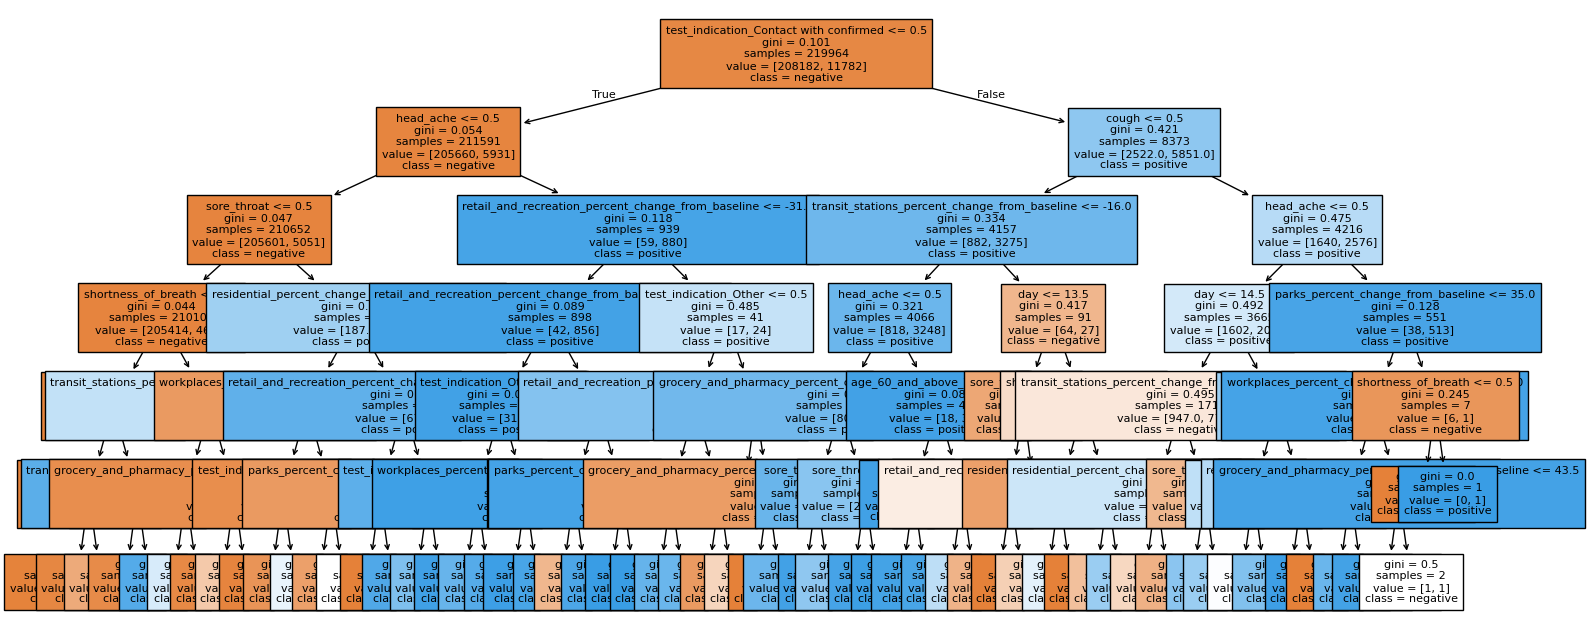

In [33]:
#Visualise if max_depth is preset to something lowish
plt.figure(figsize=(18, 8))
plot_tree(dtc, feature_names=X_train.columns, class_names=np.unique(y_train.values),fontsize=8, filled=True)
plt.show()

In [34]:
#Make predictions
preds = dtc.predict(X_test)
print(preds)

['negative' 'negative' 'negative' ... 'negative' 'negative' 'negative']


#### **Evaluation**

In [35]:
c_rep = classification_report(y_test,preds)
print(c_rep)

              precision    recall  f1-score   support

    negative       0.98      0.99      0.98     52045
    positive       0.79      0.58      0.67      2946

    accuracy                           0.97     54991
   macro avg       0.88      0.79      0.83     54991
weighted avg       0.97      0.97      0.97     54991



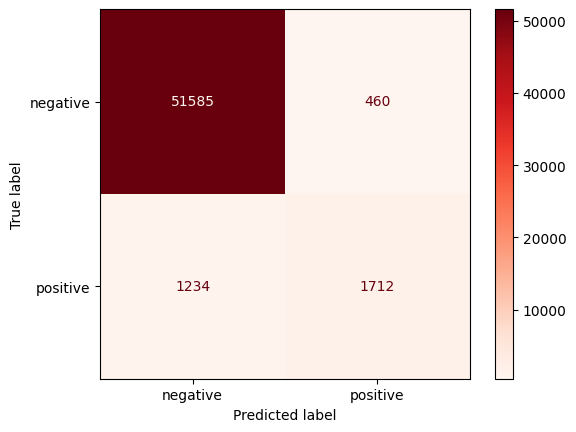

In [36]:
cm = confusion_matrix(y_test, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
disp.plot(cmap=plt.cm.Reds)
plt.show()

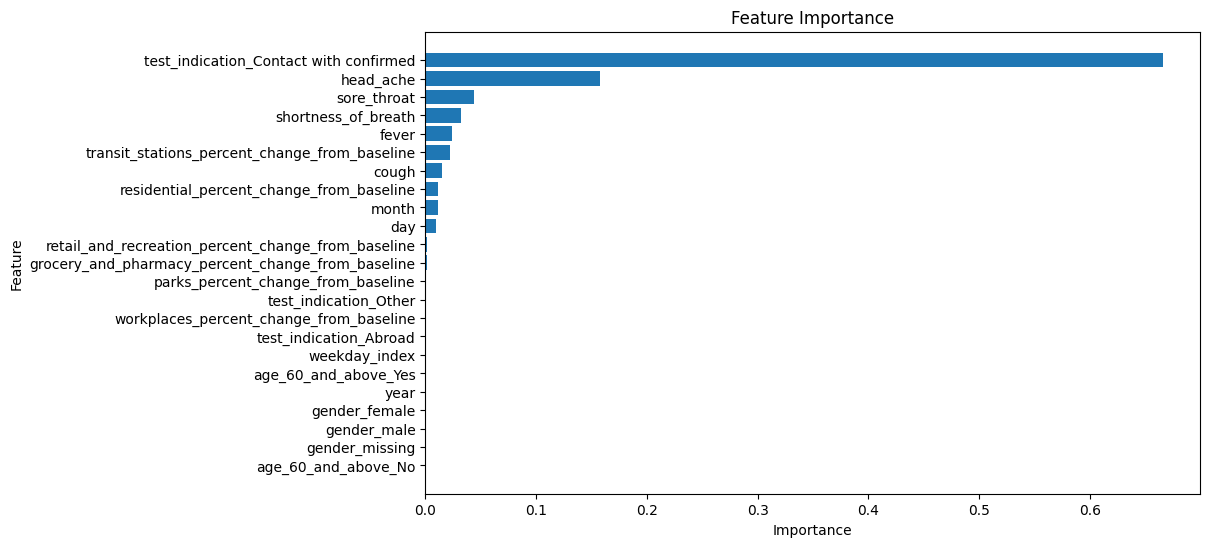

In [37]:
#Feature importance

#Extract feature importances
feature_importances = dtc.feature_importances_
features = X.columns

#Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

#Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [38]:
#Try and distil to an overall score

#Make predictions and calculate probabilities
pred_prob = dtc.predict_proba(X_test)

#Get probs for positive test
pred_prob_pos = pred_prob[:, 1]  # Get the probabilities for the positive class

#Calculate the AUC
auc_score = roc_auc_score(y_test, pred_prob_pos)
print(f'ROC_AUC: {auc_score}')

ROC_AUC: 0.879258086293671


### **Oversampling**

In [39]:
# Get rows where any column has NaN values
nan_rows_any = X_train[X_train.isna().any(axis=1)]

print(nan_rows_any)


Empty DataFrame
Columns: [cough, fever, sore_throat, shortness_of_breath, head_ache, retail_and_recreation_percent_change_from_baseline, grocery_and_pharmacy_percent_change_from_baseline, parks_percent_change_from_baseline, transit_stations_percent_change_from_baseline, workplaces_percent_change_from_baseline, residential_percent_change_from_baseline, month, day, year, weekday_index, test_indication_Abroad, test_indication_Contact with confirmed, test_indication_Other, gender_female, gender_male, gender_missing, age_60_and_above_No, age_60_and_above_Yes]
Index: []

[0 rows x 23 columns]


In [40]:
smote = SMOTE(sampling_strategy=1,random_state=90210)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#Check new valuecounts
y_train_res.value_counts(normalize=True)

corona_result
negative    0.5
positive    0.5
Name: proportion, dtype: float64

In [41]:
dtc_smoted = DecisionTreeClassifier(max_depth=6)

dtc_smoted.fit(X_train_res, y_train_res)

DecisionTreeClassifier(max_depth=6)

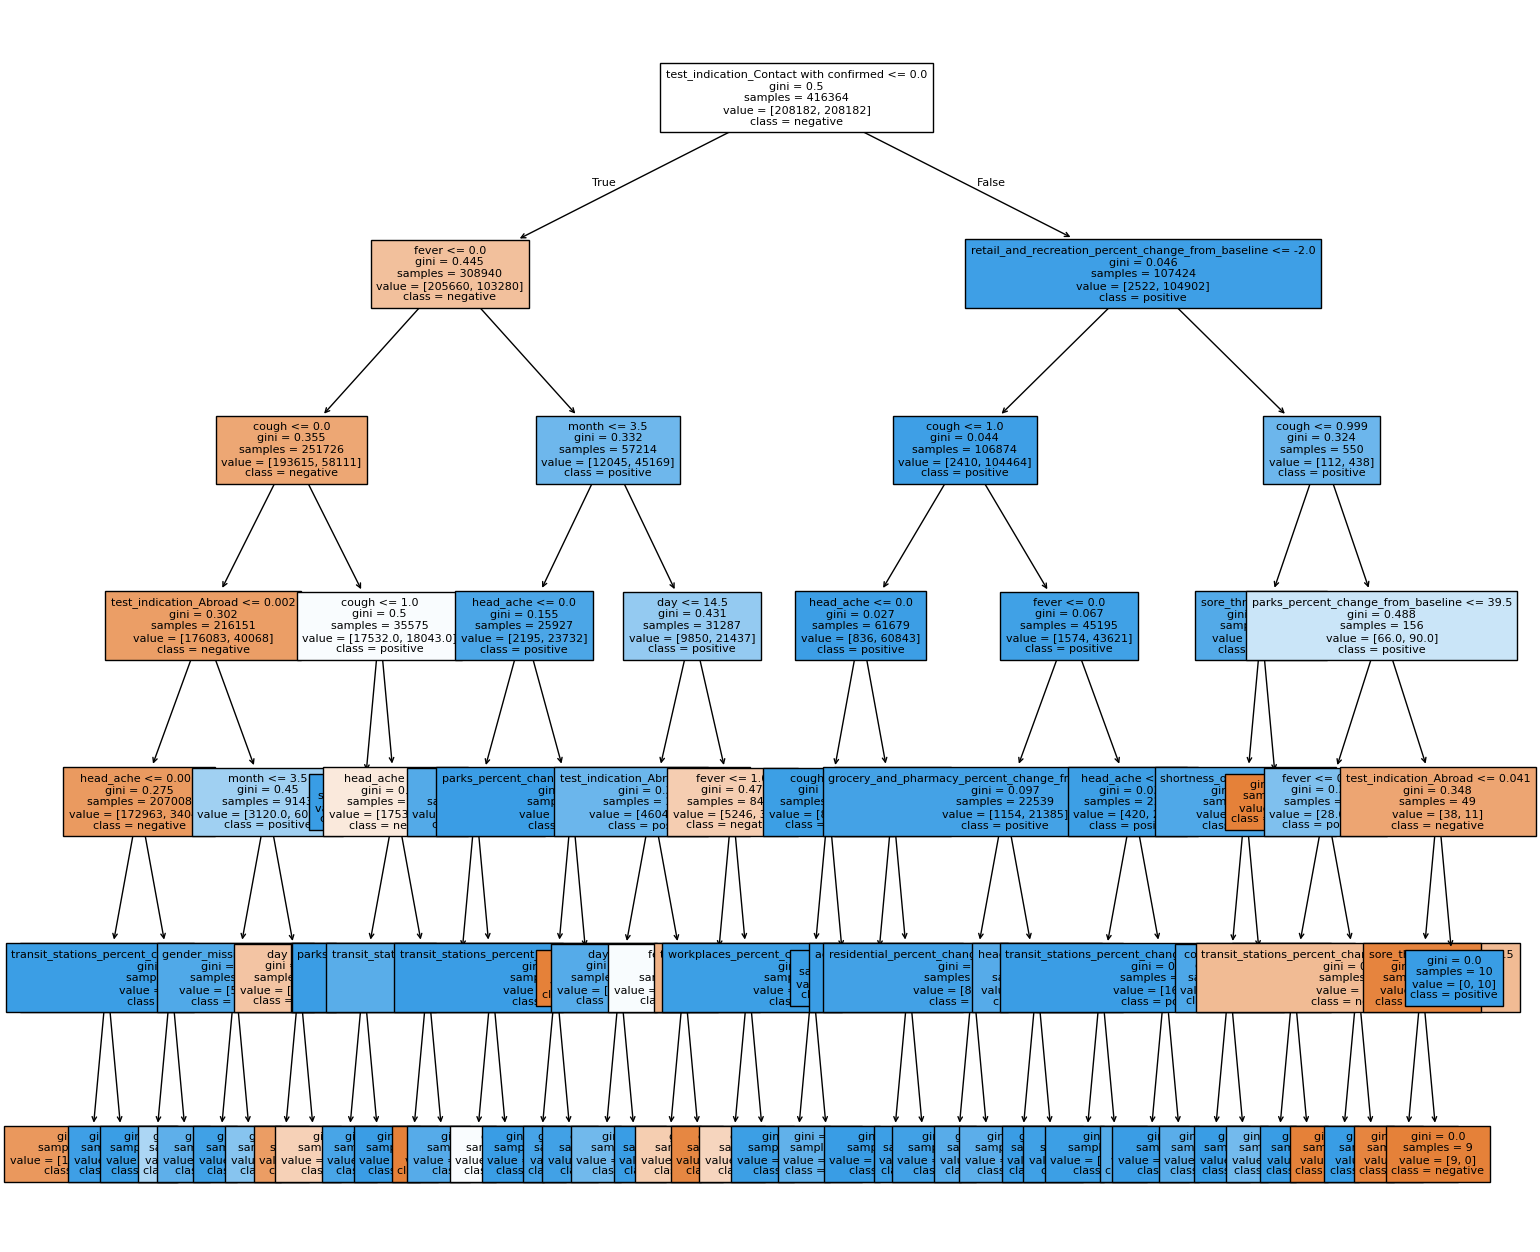

In [42]:
#Visualise if max_depth is preset to something lowish
plt.figure(figsize=(18, 16))
plot_tree(dtc_smoted, feature_names=X_train.columns, class_names=np.unique(y_train.values),fontsize=8, filled=True)
plt.show()

In [43]:
#Make predictions
preds_smoted = dtc_smoted.predict(X_test)
print(preds_smoted)

['negative' 'negative' 'negative' ... 'negative' 'negative' 'negative']


#### **Evaluation**

In [44]:
c_rep = classification_report(y_test,preds_smoted)
print(c_rep)

              precision    recall  f1-score   support

    negative       0.98      0.96      0.97     52045
    positive       0.52      0.74      0.61      2946

    accuracy                           0.95     54991
   macro avg       0.75      0.85      0.79     54991
weighted avg       0.96      0.95      0.95     54991



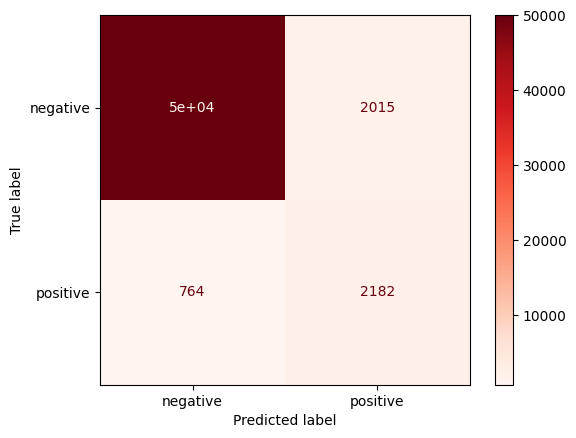

In [45]:
cm_smoted = confusion_matrix(y_test, preds_smoted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_smoted, display_labels=dtc_smoted.classes_)
disp.plot(cmap=plt.cm.Reds)
plt.show()

In [46]:
#Try and distil to an overall score

#Make predictions and calculate probabilities
pred_prob_smoted = dtc_smoted.predict_proba(X_test)

#Get probs for positive test
pred_prob_pos_smoted = pred_prob_smoted[:, 1]  # Get the probabilities for the positive class

#Calculate the AUC
auc_score_smoted = roc_auc_score(y_test, pred_prob_pos_smoted)
print(f'AUC: {auc_score_smoted}')

AUC: 0.8906353658777585


                                              Feature  Importance
16             test_indication_Contact with confirmed    0.537252
1                                               fever    0.252189
0                                               cough    0.068165
15                             test_indication_Abroad    0.043427
4                                           head_ache    0.030311
12                                                day    0.024378
11                                              month    0.023207
2                                         sore_throat    0.015343
17                              test_indication_Other    0.003424
8       transit_stations_percent_change_from_baseline    0.001138
20                                     gender_missing    0.000299
5   retail_and_recreation_percent_change_from_base...    0.000293
6   grocery_and_pharmacy_percent_change_from_baseline    0.000204
7                  parks_percent_change_from_baseline    0.000194
10        

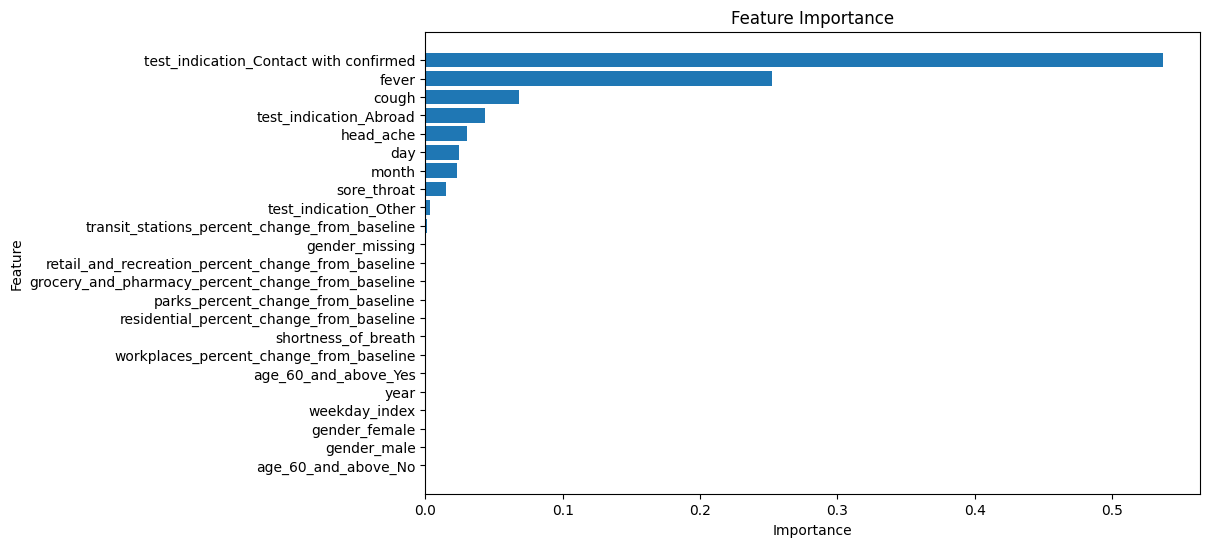

In [47]:
#Feature importance
# Extract feature importances
feature_importances_smoted = dtc_smoted.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df_smoted = pd.DataFrame({'Feature': features, 'Importance': feature_importances_smoted})

# Sort the DataFrame by importance
importance_df_smoted = importance_df_smoted.sort_values(by='Importance', ascending=False)

print(importance_df_smoted)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_smoted['Feature'], importance_df_smoted['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

**Conclusion**

Applying smote to upsample positive cases seems to have a positive impact on performance - pick this as our base going forwards?

### **Tuned Decision Tree**

In [48]:
#Set params dict to look over

param_grid = {'max_depth':range(2,12,2),
          'min_samples_split':range(20,100,20)}


dtc_tuned = DecisionTreeClassifier()

search = GridSearchCV(dtc_tuned, param_grid, cv=5)

search.fit(X_train_res, y_train_res)



GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(2, 12, 2),
                         'min_samples_split': range(20, 100, 20)})

In [49]:
#Extract best params
best_params = search.best_params_

#Fit with best params
dtc_tuned.set_params(**best_params)

dtc_tuned.fit(X_train_res,y_train_res)


DecisionTreeClassifier(max_depth=10, min_samples_split=20)

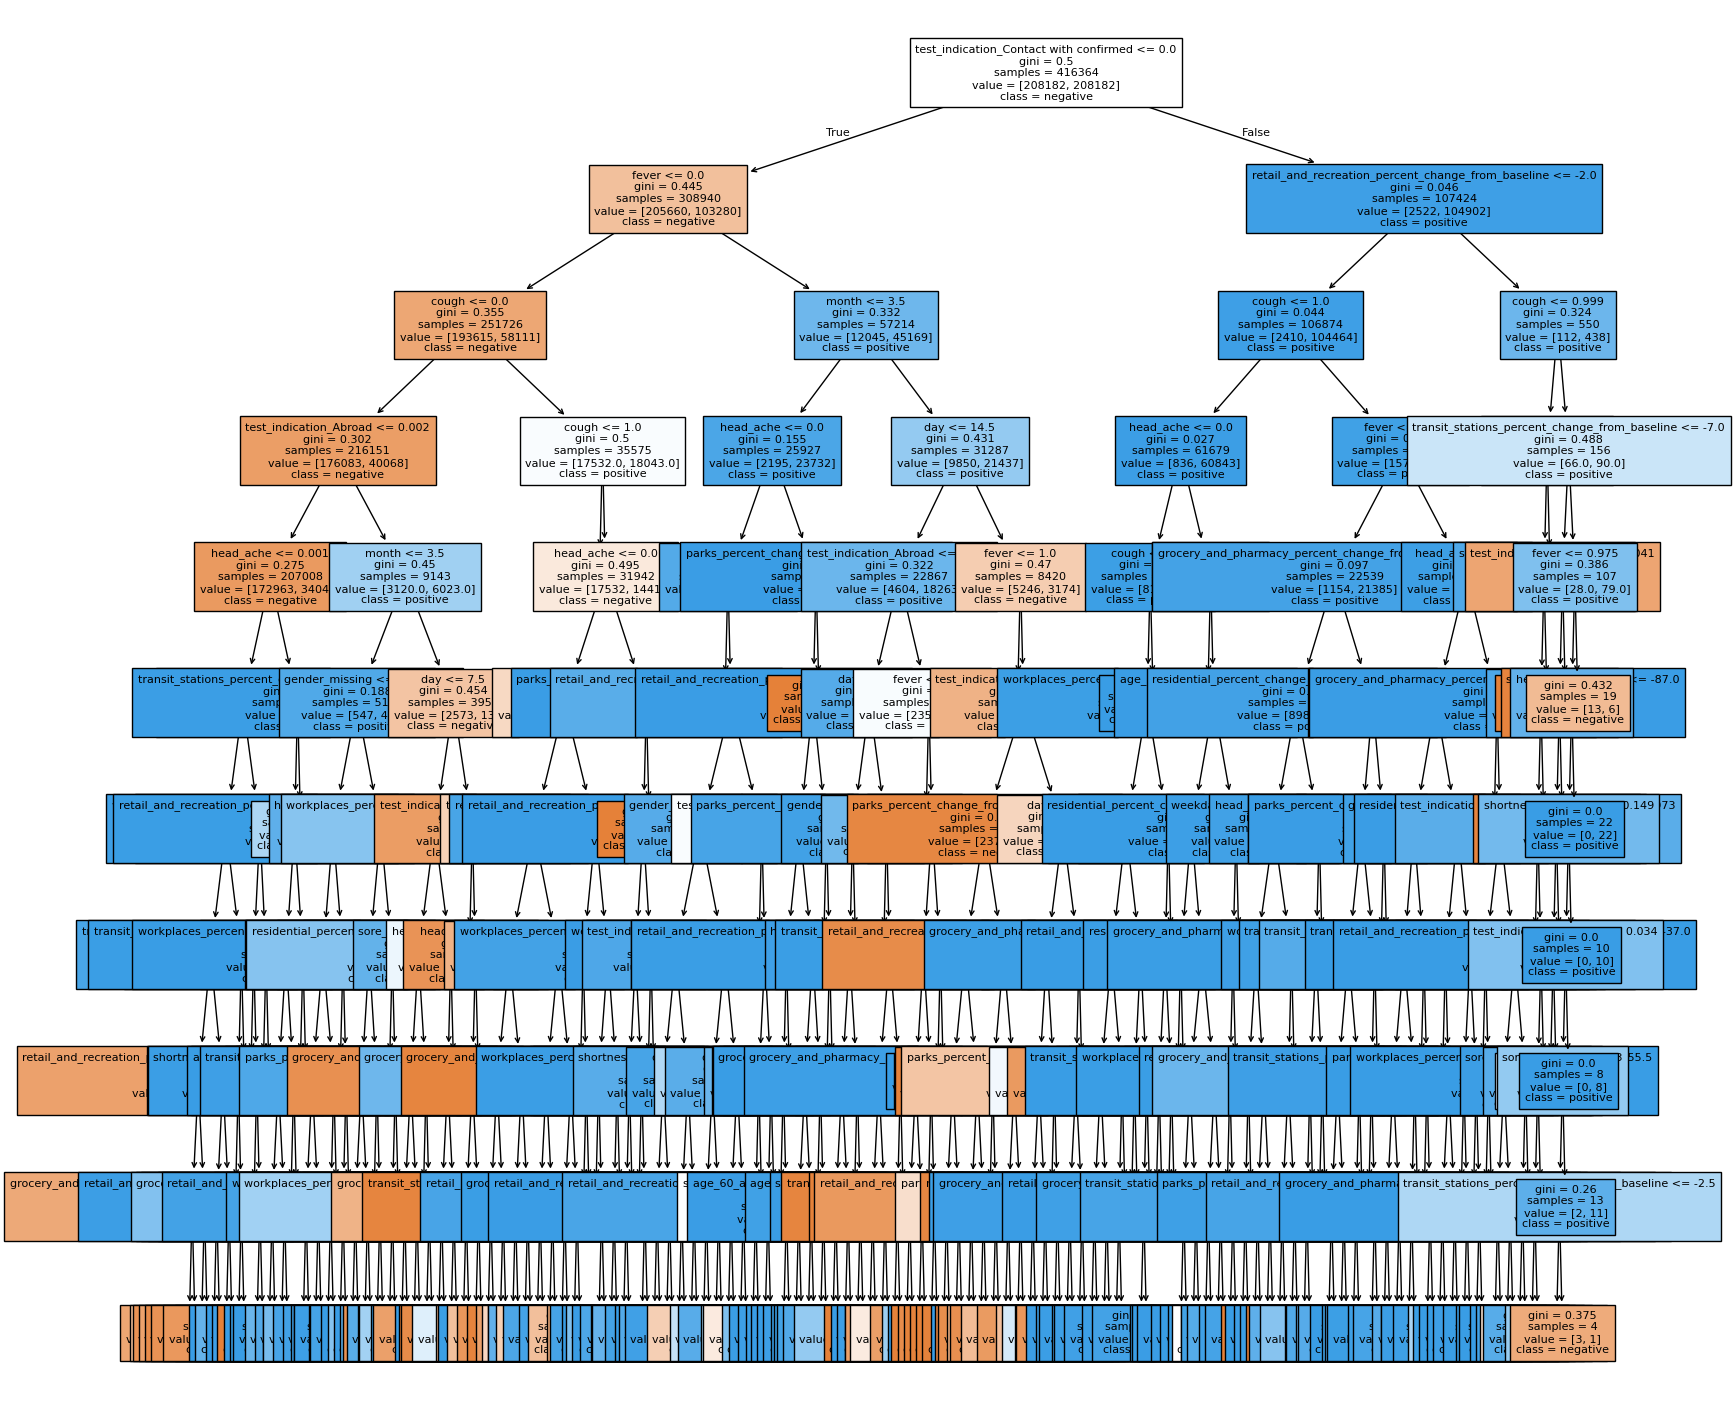

In [50]:
#Visualise if max_depth is preset to something lowish
plt.figure(figsize=(18, 18))
plot_tree(dtc_tuned, feature_names=X_train_res.columns, class_names=np.unique(y_train_res.values),fontsize=8, filled=True)
plt.show()

In [51]:
preds_tuned = dtc_tuned.predict(X_test)
preds_tuned

array(['negative', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [52]:
#Try and distil to an overall score

#Make predictions and calculate probabilities
pred_prob_tuned = dtc_tuned.predict_proba(X_test)

#Get probs for positive test
pred_prob_pos_tuned = pred_prob_tuned[:, 1]  # Get the probabilities for the positive class

### **Evaluation**

In [53]:
#Calculate the AUC
rocauc_score_tuned = roc_auc_score(y_test, pred_prob_pos_tuned)
print(f'ROC_AUC: {rocauc_score_tuned}')

ROC_AUC: 0.9015155561825481


In [54]:
c_rep_tuned = classification_report(y_test,preds_tuned)
print(c_rep_tuned)

              precision    recall  f1-score   support

    negative       0.99      0.96      0.97     52045
    positive       0.49      0.76      0.60      2946

    accuracy                           0.95     54991
   macro avg       0.74      0.86      0.78     54991
weighted avg       0.96      0.95      0.95     54991



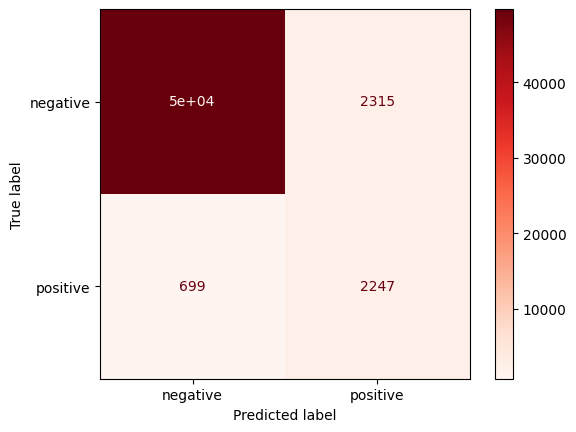

In [55]:
cm_tuned = confusion_matrix(y_test, preds_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=dtc_smoted.classes_)
disp.plot(cmap=plt.cm.Reds)
plt.show()

                                              Feature  Importance
16             test_indication_Contact with confirmed    0.502728
1                                               fever    0.237246
0                                               cough    0.066760
15                             test_indication_Abroad    0.043349
12                                                day    0.038337
4                                           head_ache    0.031884
11                                              month    0.026123
2                                         sore_throat    0.016390
3                                 shortness_of_breath    0.010744
17                              test_indication_Other    0.008682
19                                        gender_male    0.005213
5   retail_and_recreation_percent_change_from_base...    0.002883
6   grocery_and_pharmacy_percent_change_from_baseline    0.002201
8       transit_stations_percent_change_from_baseline    0.001867
18        

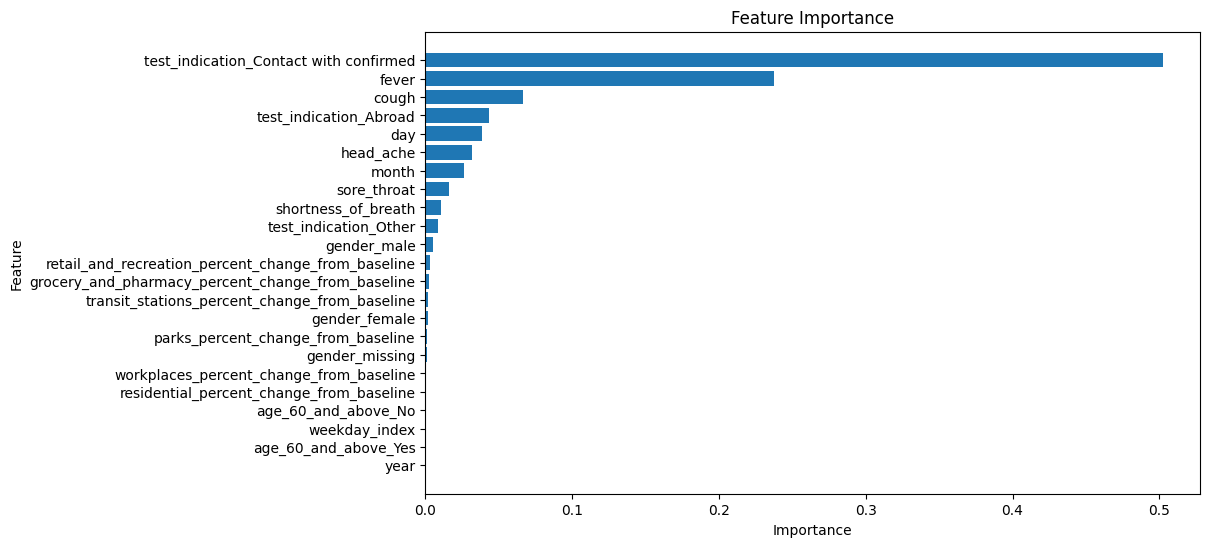

In [56]:
#Feature importance
# Extract feature importances
feature_importances_tuned = dtc_tuned.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df_tuned = pd.DataFrame({'Feature': features, 'Importance': feature_importances_tuned})

# Sort the DataFrame by importance
importance_df_tuned = importance_df_tuned.sort_values(by='Importance', ascending=False)

print(importance_df_tuned)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_tuned['Feature'], importance_df_tuned['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

### **Random Forest**

In [57]:
#Test a random forest classifier with default params - this takes a while
param_grid = {
    'n_estimators': range(200,400,100),
    'max_depth': [10],
    'min_samples_split': [20],
    'min_samples_leaf': [20]
}

rfc_mod = RandomForestClassifier()

folds = KFold(n_splits=2, shuffle=True, random_state=90210)

rfc_search = GridSearchCV(rfc_mod, param_grid, cv=folds, verbose=2)

rfc_search.fit(X_train_res, y_train_res)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=200; total time=  27.8s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=200; total time=  29.4s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=300; total time=  40.8s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=300; total time=  36.7s


GridSearchCV(cv=KFold(n_splits=2, random_state=90210, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10], 'min_samples_leaf': [20],
                         'min_samples_split': [20],
                         'n_estimators': range(200, 400, 100)},
             verbose=2)

In [58]:
#Get best params
best_params_rfc = rfc_search.best_params_
best_params_rfc

#Set best params and fit
rfc_mod.set_params(**best_params_rfc)
rfc_mod.fit(X_train_res,y_train_res)

RandomForestClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=20,
                       n_estimators=300)

In [59]:
#Make predictions
preds_rfc = rfc_mod.predict(X_test)
print(preds_rfc)

['negative' 'negative' 'negative' ... 'negative' 'negative' 'negative']


In [60]:
#Try and distil to an overall score

#Make predictions and calculate probabilities
pred_prob_rfc = rfc_mod.predict_proba(X_test)

print(pred_prob_rfc)

#Get probs for positive test
pred_prob_pos_rfc = pred_prob_rfc[:, 1]  # Get the probabilities for the positive class

[[0.75240379 0.24759621]
 [0.76989405 0.23010595]
 [0.81978407 0.18021593]
 ...
 [0.86294108 0.13705892]
 [0.76989405 0.23010595]
 [0.65552985 0.34447015]]


### **Evaluation**

In [61]:
#Calculate the AUC
rocauc_score_rfc = roc_auc_score(y_test, pred_prob_pos_rfc)
print(f'ROC_AUC: {rocauc_score_rfc}')

ROC_AUC: 0.9152285344742854


In [62]:
c_rep_rfc = classification_report(y_test,preds_rfc)
print(c_rep_rfc)

              precision    recall  f1-score   support

    negative       0.99      0.95      0.97     52045
    positive       0.46      0.79      0.58      2946

    accuracy                           0.94     54991
   macro avg       0.72      0.87      0.77     54991
weighted avg       0.96      0.94      0.95     54991



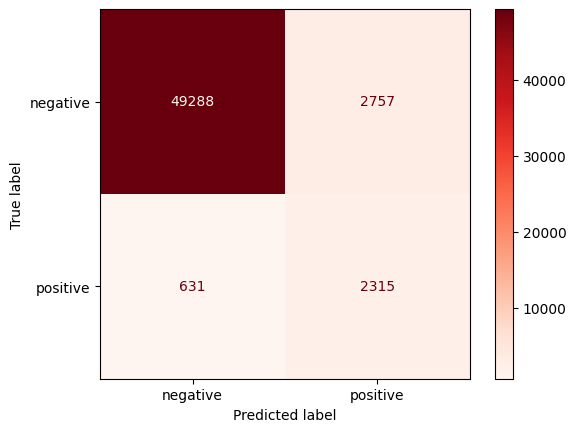

In [63]:
cm_rfc = confusion_matrix(y_test, preds_rfc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfc, display_labels=rfc_mod.classes_)
disp.plot(cmap=plt.cm.Reds)
plt.show()

                                              Feature  Importance
16             test_indication_Contact with confirmed    0.502728
1                                               fever    0.237246
0                                               cough    0.066760
15                             test_indication_Abroad    0.043349
12                                                day    0.038337
4                                           head_ache    0.031884
11                                              month    0.026123
2                                         sore_throat    0.016390
3                                 shortness_of_breath    0.010744
17                              test_indication_Other    0.008682
19                                        gender_male    0.005213
5   retail_and_recreation_percent_change_from_base...    0.002883
6   grocery_and_pharmacy_percent_change_from_baseline    0.002201
8       transit_stations_percent_change_from_baseline    0.001867
18        

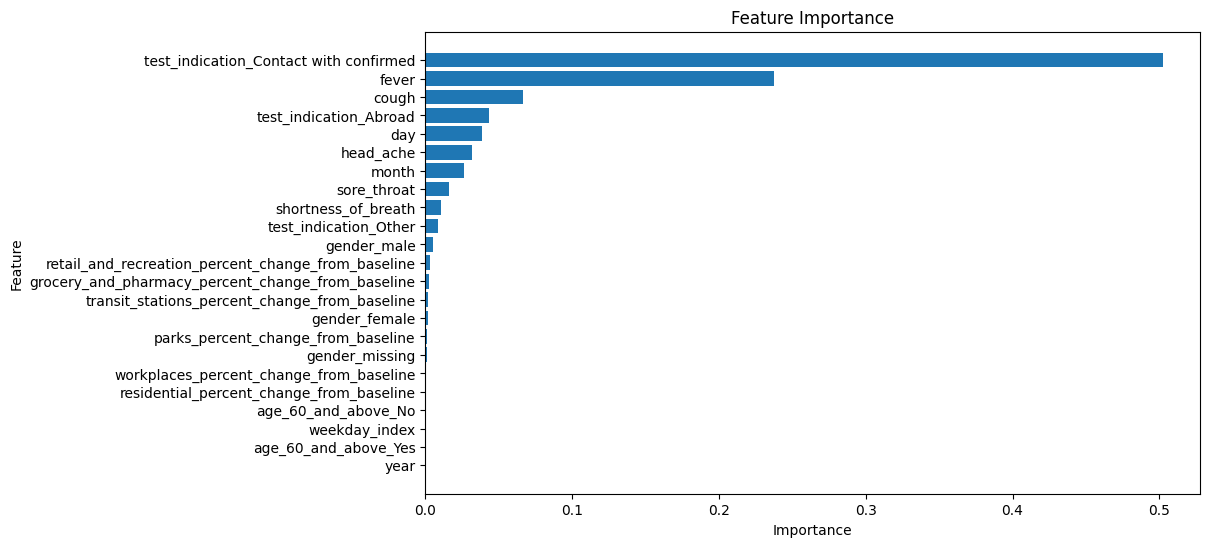

In [64]:
#Feature importance
# Extract feature importances
feature_importances_rf = rfc_mod.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_rf = pd.DataFrame({'Feature': features, 'Importance': feature_importances_tuned})

# Sort the DataFrame by importance
importance_rf = importance_rf.sort_values(by='Importance', ascending=False)

print(importance_df_tuned)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_rf['Feature'], importance_rf['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()